<a href="https://colab.research.google.com/github/MudSnail/Colab_Practice/blob/main/Quora_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


# Import packages and UDFs

In [1]:
!pip install contractions
!pip install fuzzywuzzy

     |████████████████████████████████| 106 kB 5.1 MB/s 
     |████████████████████████████████| 284 kB 6.0 MB/s 


In [2]:
#base packages
import pandas as pd
import numpy as np
import copy
from collections import  Counter

#plots
import seaborn as sns
import matplotlib.pyplot as plt

#Pre-Processing/EDA
import re
import contractions
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

#Feature Engineering
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
#Define function to count number of words in string
def plot_word_number_histogram(text):
  text.str.split().\
    map(lambda x: len(x)).\
    hist()

#plot stop words
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

#def for filter words of string with sublist
def Filter(string, substr):
  return[str for str in string if any(sub in str for sub in substr)]

#define list of question words
question_words = ['Who', 'What', 'Where', 'How', 'When', 'Can', 'If', 'Is']

#define function to plot top questions
def plot_top_questions_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    counter=Counter(corpus)

    #apply filter function
    ls = Filter(counter, question_words)

    #create set in counter dictionary to remove based on key matching ls
    to_remove = set()
    for key, value in counter.items():
      if key not in ls:
        to_remove.add(key)

    #delete keys in to_remove
    for key in to_remove:
      del counter[key]

    #Select most common and count
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:9]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    #plot        
    sns.barplot(x=y,y=x) 

#define function to plot ngrams, no stopwords
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)


#define function to plot wordcloud
def plot_wordcloud(text):
    stop=set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()

#define function to remove contractions and stopwords
def remove_stopwords_contractions(text):
  stop=set(stopwords.words('english'))
  #remove contractions and join back into string
  text = contractions.fix(text)
  #remove stop words
  text = ' '.join([word for word in text.split() if word not in stop])
  return text

#define function to stem text
def stem_text(text):
  #instantiate stemmer
  porter = PorterStemmer()
  #tokentize
  words = word_tokenize(text)
  #stem text
  stemmed_text = ' '.join([porter.stem(word) for word in words])
  return stemmed_text

# Import Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv("/content/drive/MyDrive/Deep_Learning/train.csv")
print(df.shape)

(404290, 6)


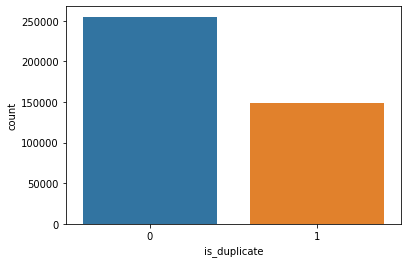

In [7]:
#count positive and negative
sns.countplot(data=df, x ='is_duplicate')

In [8]:
print("Total number of question pairs:", len(df))
print('Percentage of question pairs that are not similar (is_duplicate = 0): {}%'.format(100-round(df['is_duplicate'].mean()*100, 2)))
print('Percentage of question pairs that are similar (is_duplicate = 1): {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

Total number of question pairs: 404290
Percentage of question pairs that are not similar (is_duplicate = 0): 63.08%
Percentage of question pairs that are similar (is_duplicate = 1): 36.92%


This is biased, so I will create positive and negative dataframes of 140 000 each and then merge them

In [9]:
#check null values
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [10]:
#drop null rows
df = df.dropna()
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [11]:
positive = df[df['is_duplicate'] == 1].sample(140000)
negative = df[df['is_duplicate'] == 0].sample(140000)

#Combine positive and negative
new_df = pd.concat([positive, negative], ignore_index=True)

#shuffle rows and reset index
new_df = new_df.sample(frac = 1).reset_index(drop = True)

print(new_df.shape)
new_df.head()

(280000, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,282068,401946,401947,What is the distance between The Sun and Earth?,What is the distance between Earth and the Sun?,1
1,26214,48815,24555,How do I see how many followers do I have afte...,How do l see who viewed my videos on Instagram?,0
2,396263,529311,529312,Where do identical twins have different finger...,Do identical twins have the same fingerprints?,0
3,356499,84655,485821,How long does it take to install Windows 10?,Why does it take so long to update Windows?,0
4,271929,390112,390113,What were General Shang's wife's last words in...,What U.S. films are about water polo?,0


## Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

In [12]:
#create train and test datasets
train = new_df[:224000] #80%
test = new_df[224000:] #20%

#view train
train.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,282068,401946,401947,What is the distance between The Sun and Earth?,What is the distance between Earth and the Sun?,1
1,26214,48815,24555,How do I see how many followers do I have afte...,How do l see who viewed my videos on Instagram?,0
2,396263,529311,529312,Where do identical twins have different finger...,Do identical twins have the same fingerprints?,0
3,356499,84655,485821,How long does it take to install Windows 10?,Why does it take so long to update Windows?,0
4,271929,390112,390113,What were General Shang's wife's last words in...,What U.S. films are about water polo?,0


In [13]:
test.head()

,id,qid1,qid2,question1,question2,is_duplicate
224000,288644,409626,100923,Do employees at Ultimate Software Group have a...,Do employees at The Container Store Group have...,0
224001,153908,241477,241478,I fell a tree that was in my yard. How can I m...,Is there a way to watch this Turkish series ca...,0
224002,107099,176280,170982,How is the process of getting pregnant on a fe...,Why can I only get pregnant on my fertile days?,1
224003,154600,60493,242403,What is the most dangerous city in USA? Why?,What is the most dangerous US city? Why is it ...,1
224004,201419,303423,279912,What is the reaction between Calcium Carbonate...,What is the reaction caused by magnesium carbo...,0


# Exploration

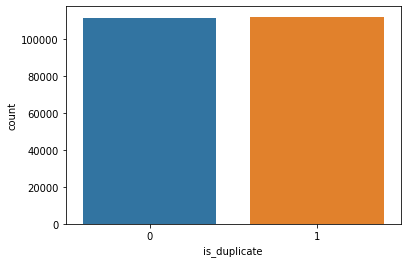

In [ ]:
#count positive and negative
sns.countplot(data=train, x ='is_duplicate')

We can see we have way more classifications are now fairly even

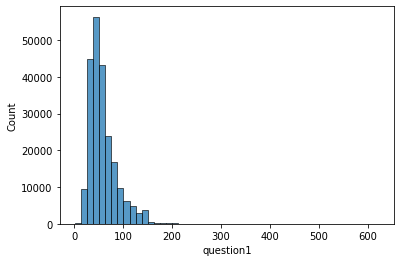

In [ ]:
#Number of characters in question 1
sns.histplot(data=train, x = train.question1.str.len(), bins=50)

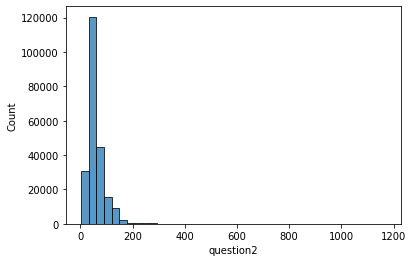

In [ ]:
#number of characters in question 2
sns.histplot(data=train, x = train.question2.str.len(), bins=40)

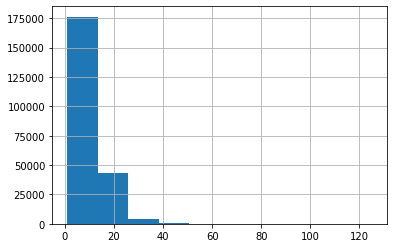

In [ ]:
#Number of words in question 1
plot_word_number_histogram(train['question1'])

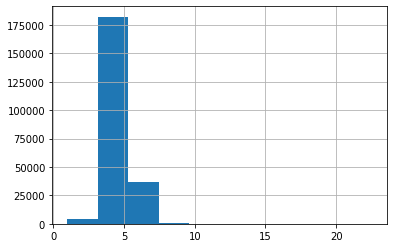

In [ ]:
#average word length for each question for question 1
train['question1'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

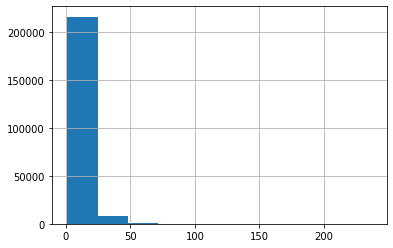

In [ ]:
#Number of words in question 2
plot_word_number_histogram(train['question2'])

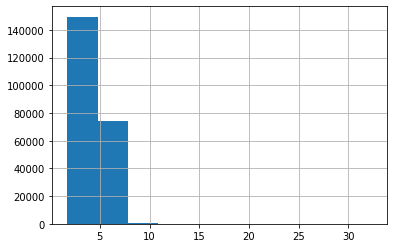

In [ ]:
#average word length for question 2
train['question2'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

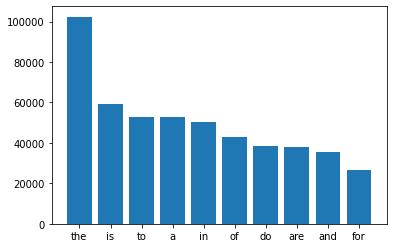

In [ ]:
plot_top_stopwords_barchart(train['question1'])

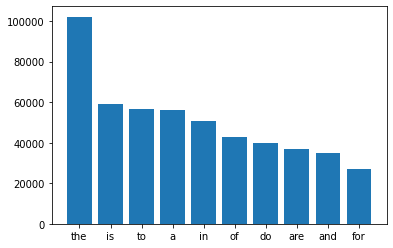

In [ ]:
plot_top_stopwords_barchart(train['question2'])

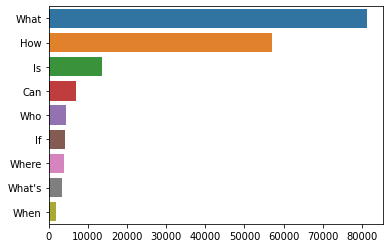

In [ ]:
plot_top_questions_barchart(train['question1'])

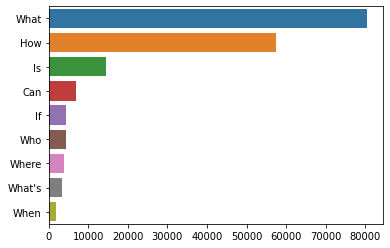

In [ ]:
plot_top_questions_barchart(train['question2'])

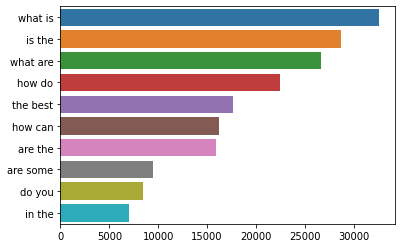

In [ ]:
#top bigrams of question 1
plot_top_ngrams_barchart(train['question1'],2)

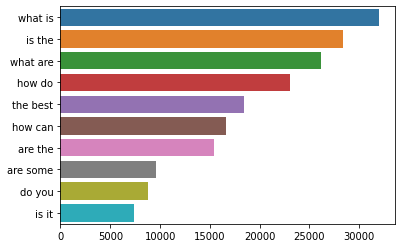

In [ ]:
#top bigrams of question 2
plot_top_ngrams_barchart(train['question2'],2)

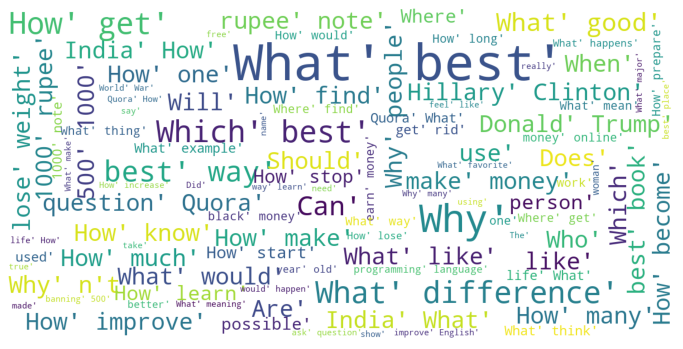

In [ ]:
plot_wordcloud(train['question1'])

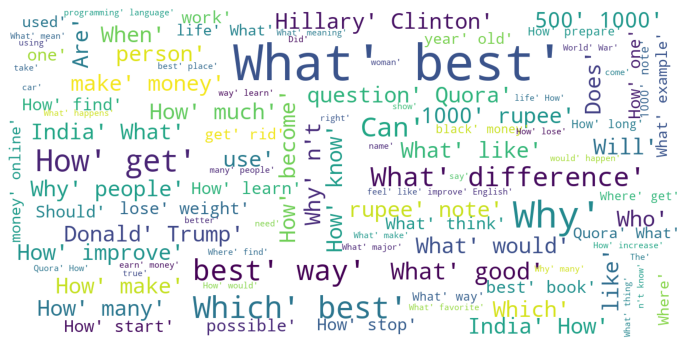

In [ ]:
plot_wordcloud(train['question2'])

# Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [14]:
#create deep copy of train
fix_data = copy.deepcopy(train)

In [15]:
#remove stopwords and contractions from questions
fix_data['question1'] = fix_data['question1'].apply(lambda x: remove_stopwords_contractions(x)).tolist()
fix_data['question2'] = fix_data['question2'].apply(lambda x: remove_stopwords_contractions(x)).tolist()

In [16]:
#extract column, apply lower casing, replace specific strings, remove, punc and add to DF
text_q1 = train['question1']

# Lowercasing
text_q1 = text_q1.str.lower()

#replace specific string characters with words
text_q1 = text_q1.str.replace('%', ' percent ', regex = True)
text_q1 = text_q1.str.replace('inr', ' rupee ', regex = True)
text_q1 = text_q1.str.replace('$', ' dollar ', regex = True)
text_q1 = text_q1.str.replace('₹', ' rupee ', regex = True)
text_q1 = text_q1.str.replace('@', ' at ', regex = True)
text_q1 = text_q1.str.replace('€', ' euro ', regex = True)

# #replacing numbers with strings
# text_q1 = text_q1.str.replace()


#remove punctuation
text_q1 = text_q1.str.replace(r'[^\w\s]', ' ', regex = True)

#add text back to dataframe
fix_data['new_q1'] = text_q1

In [17]:
#extract column, apply lower casing, replace specific strings, remove, punc and add to DF
text_q2 = train['question2']

# Lowercasing
text_q2 = text_q2.str.lower()

#replace specific string characters with words
text_q2 = text_q2.str.replace('%', ' percent ', regex = True)
text_q2 = text_q2.str.replace('inr', ' rupee ', regex = True)
text_q2 = text_q2.str.replace('$', ' dollar ', regex = True)
text_q2 = text_q2.str.replace('₹', ' rupee ', regex = True)
text_q2 = text_q2.str.replace('@', ' at ', regex = True)
text_q2 = text_q2.str.replace('€', ' euro ', regex = True)

#remove punctuation
text_q2 = text_q2.str.replace(r'[^\w\s]', '', regex = True)

#add text back to dataframe
fix_data['new_q2'] = text_q2

In [18]:
#apply stem text
fix_data['new_q1'] = fix_data['new_q1'].apply(lambda x: stem_text(x))
fix_data['new_q2'] = fix_data['new_q2'].apply(lambda x: stem_text(x))

In [19]:
#view new dataframe
fix_data.head()

,id,qid1,qid2,question1,question2,is_duplicate,new_q1,new_q2
0,282068,401946,401947,What distance The Sun Earth?,What distance Earth Sun?,1,what is the distanc between the sun and earth,what is the distanc between earth and the sun
1,26214,48815,24555,How I see many followers I 10k instagram?,How l see viewed videos Instagram?,0,how do i see how mani follow do i have after 1...,how do l see who view my video on instagram
2,396263,529311,529312,Where identical twins different fingerprints ?,Do identical twins fingerprints?,0,where do ident twin have differ fingerprint,do ident twin have the same fingerprint
3,356499,84655,485821,How long take install Windows 10?,Why take long update Windows?,0,how long doe it take to instal window 10,whi doe it take so long to updat window
4,271929,390112,390113,What General Shang's wife's last words Arrival?,What YOU.S. films water polo?,0,what were gener shang s wife s last word in arriv,what us film are about water polo


## Apply to Test Data

In [ ]:
#remove stopwords and contractions from questions
test['question1'] = test['question1'].apply(lambda x: remove_stopwords_contractions(x)).tolist()
test['question2'] = test['question2'].apply(lambda x: remove_stopwords_contractions(x)).tolist()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#extract column, apply lower casing, replace specific strings, remove, punc and add to DF
text_q1_test = test['question1']

# Lowercasing
text_q1_test = text_q1_test.str.lower()

#replace specific string characters with words
text_q1_test = text_q1_test.str.replace('%', ' percent ', regex = True)
text_q1_test = text_q1_test.str.replace('inr', ' rupee ', regex = True)
text_q1_test = text_q1_test.str.replace('$', ' dollar ', regex = True)
text_q1_test = text_q1_test.str.replace('₹', ' rupee ', regex = True)
text_q1_test = text_q1_test.str.replace('@', ' at ', regex = True)
text_q1_test = text_q1_test.str.replace('€', ' euro ', regex = True)

#remove punctuation
text_q1_test = text_q1_test.str.replace(r'[^\w\s]', '', regex = True)

#add text back to dataframe
test['new_q1'] = text_q1_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
#extract column, apply lower casing, replace specific strings, remove, punc and add to DF
text_q2_test = test['question2']

# Lowercasing
text_q2_test = text_q2_test.str.lower()

#replace specific string characters with words
text_q2_test = text_q2_test.str.replace('%', ' percent ', regex = True)
text_q2_test = text_q2_test.str.replace('inr', ' rupee ', regex = True)
text_q2_test = text_q2_test.str.replace('$', ' dollar ', regex = True)
text_q2_test = text_q2_test.str.replace('₹', ' rupee ', regex = True)
text_q2_test = text_q2_test.str.replace('@', ' at ', regex = True)
text_q2_test = text_q2_test.str.replace('€', ' euro ', regex = True)

#remove punctuation
text_q2_test = text_q2_test.str.replace(r'[^\w\s]', '', regex = True)

#add text back to dataframe
test['new_q2'] = text_q2_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
#apply stem text
test['new_q1'] = test['new_q1'].apply(lambda x: stem_text(x))
test['new_q2'] = test['new_q2'].apply(lambda x: stem_text(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
test.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,new_q1,new_q2
224000,382159,513976,476205,Why fishes die deep sea? How survive much high...,How deep sea creatures survive high water pres...,1,whi fish die deep sea how surviv much high pre...,how deep sea creatur surviv high water pressur
224001,366631,496852,496853,Was Benjamin Franklin serial killer?,American Revolution Revolutionary War: Why Ben...,0,wa benjamin franklin serial killer,american revolut revolutionari war whi benjami...
224002,25533,47582,47583,What top universities Germany MS civil enginee...,Which best universities Germany civil engneeri...,1,what top univers germani ms civil engin,which best univers germani civil engneer ms


# Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

## Create New Features

- number of characters per question
- number of words per question
- total number of words (q1 +q1)
- total number of characters
- number of common words

Try fuzzywuzzy:
- fuzz_ratio score
- fuzz_partial_ratio score

In [20]:
#calculate number of characters per question
fix_data['no_char_q1'] = fix_data.apply(lambda x: len(x['new_q1']), axis = 1)
fix_data['no_char_q2'] = fix_data.apply(lambda x: len(x['new_q2']), axis = 1)

#difference between characters
fix_data['diff_count_char'] = abs(fix_data['no_char_q2'] - fix_data['no_char_q1'])

#total number of characters
fix_data['total_no_char'] = fix_data['no_char_q1'] + fix_data['no_char_q2']

In [21]:
#count number of words per question
fix_data['no_words_q1'] = fix_data.apply(lambda x: len(x['new_q1'].split()), axis = 1)
fix_data['no_words_q2'] = fix_data.apply(lambda x: len(x['new_q2'].split()), axis = 1)

#difference between words
fix_data['diff_word'] = abs(fix_data['no_words_q2'] - fix_data['no_words_q1'])

#total number of words
fix_data['total_word'] = fix_data['no_words_q1'] + fix_data['no_words_q2']

In [22]:
#calculate the number of common words between 2 strings
def number_common_words(col_1, col_2):
    q1_words = set(col_1)
    q2_words = set(col_2)
    common_words =  q1_words & q2_words
    return len(common_words)

#number of common words
fix_data['no_com_words'] = fix_data.apply(lambda x: number_common_words(x['new_q1'].split(),x['new_q2'].split()), axis = 1)


In [23]:
#fuzz partial ratio - Levenshtein distance
fix_data['simarlity_rating'] = fix_data.apply(lambda x: fuzz.partial_ratio(x['new_q1'],x['new_q2']), axis = 1)
fix_data['simarlity_rating'] = fix_data['simarlity_rating']/100

### Apply to test

In [ ]:
#apply get_features to dataframe
new_test = get_features(test)

#view new dataframe
new_test.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

,id,qid1,qid2,question1,question2,is_duplicate,new_q1,new_q2,char_q1,char_q2,...,diff_word,total_char,total_word,com_words,freq_qid1,freq_qid2,freq_sum,freq_diff,fuzz_ratio,fuzz_partial_ratio
224000,359120,488725,373972,"Has boss ever told ""paid this"". If so, make feel?",How give speech nervous make brain blank? It m...,0,ha boss ever told paid thi if so make feel,how give speech nervou make brain blank it mak...,42,57,...,0,99,20,1,1,1,2,0,30,33
224001,108061,98251,54038,What best way start learning programming?,How I start learning programming language? Whi...,1,what best way start learn program,how i start learn program languag which one st...,33,54,...,4,87,16,3,4,3,7,1,51,67
224002,218374,324959,265584,Is scrapping Rs.500 Rs.1000 currency notes fig...,Will scrapping currency notes India really aff...,1,is scrap rs500 rs1000 currenc note fight black...,will scrap currenc note india realli affect pe...,81,61,...,4,142,24,5,1,1,2,0,49,57


## Analyze new features

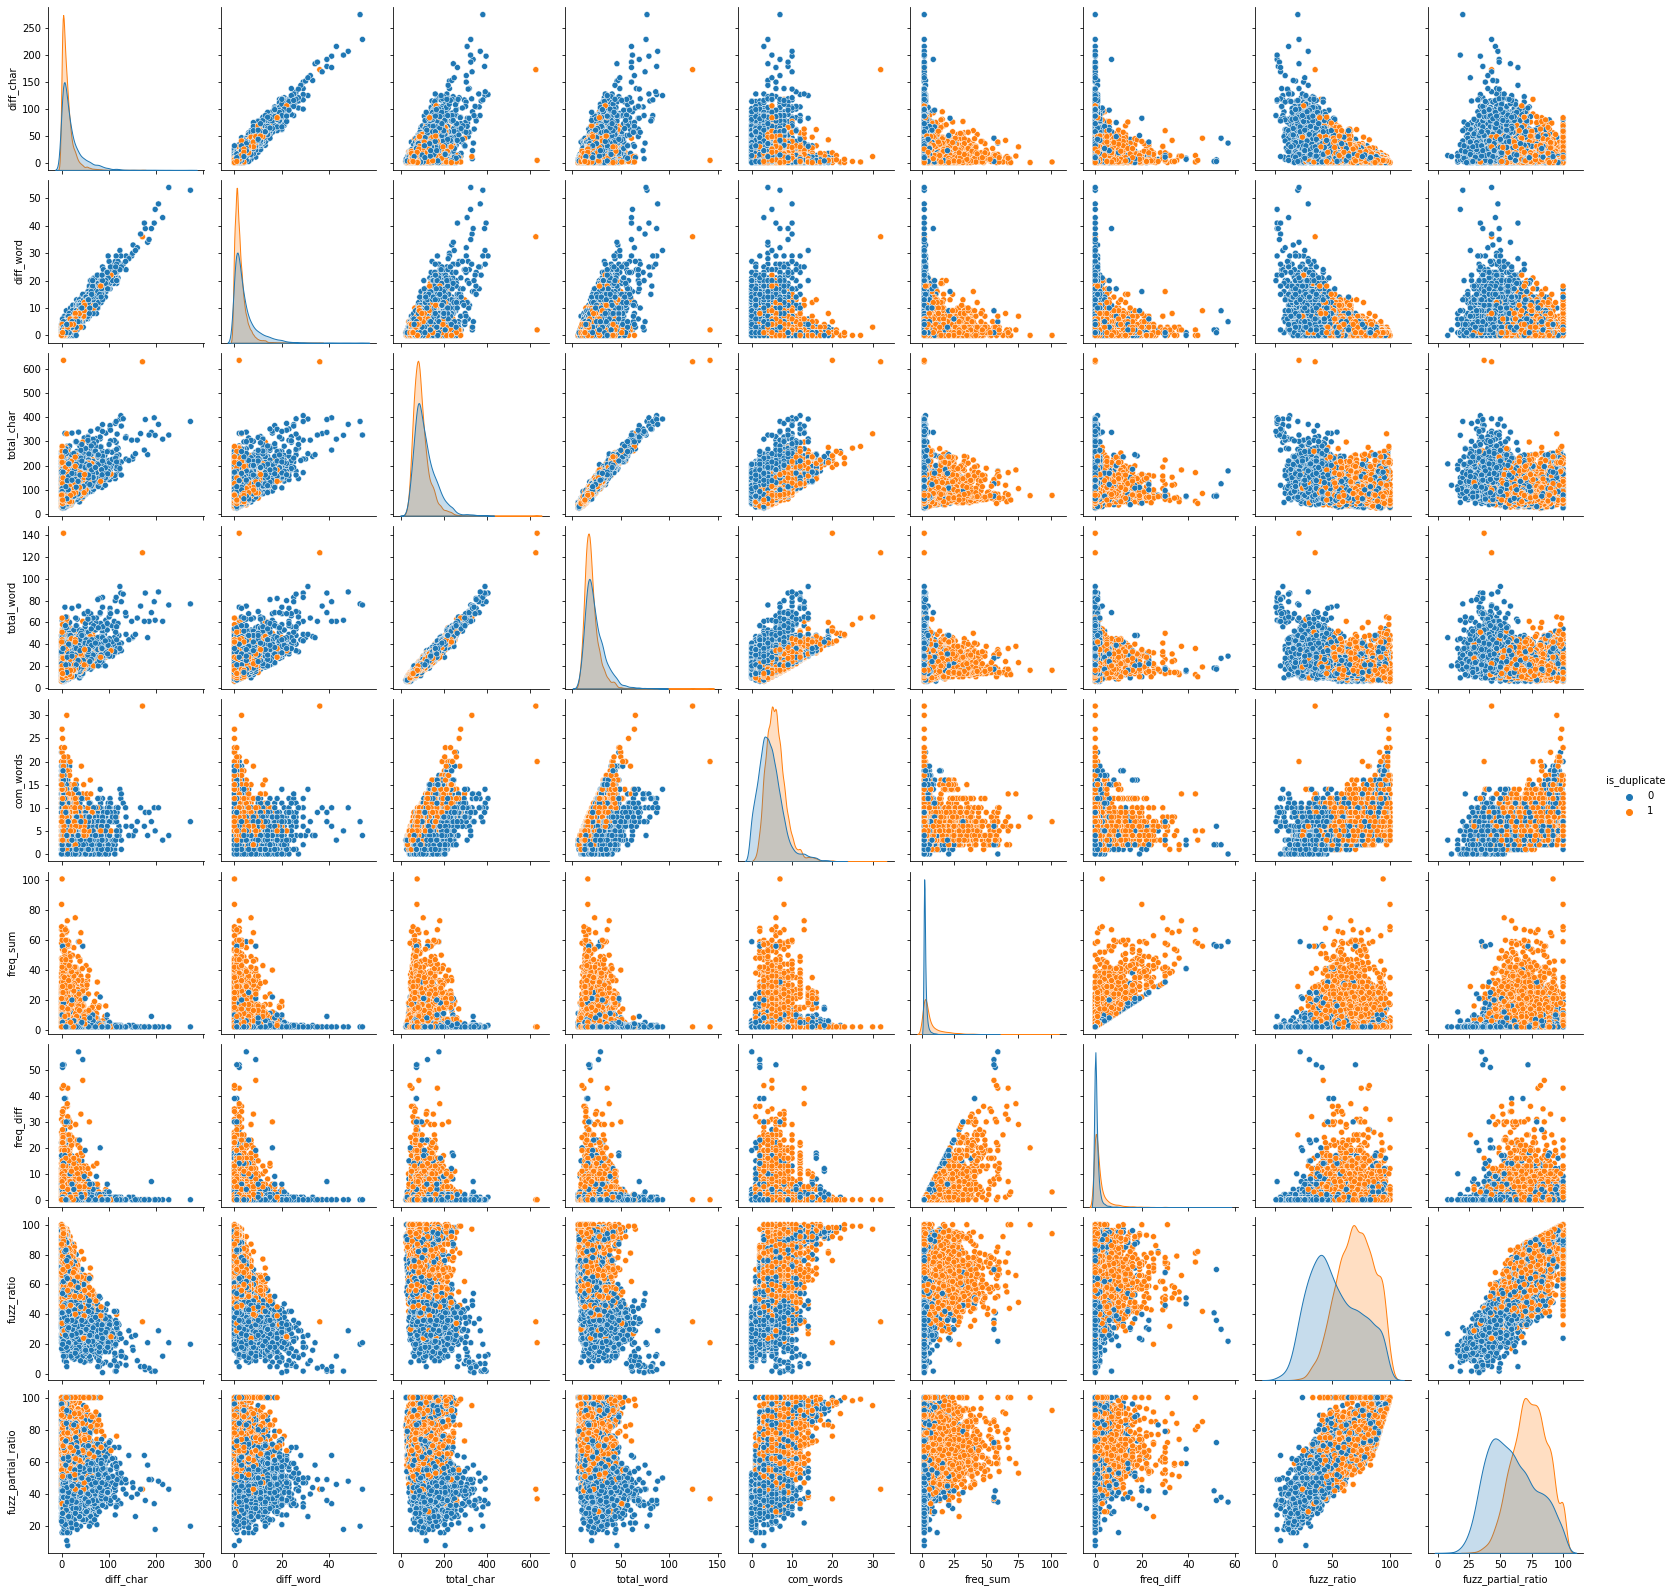

In [ ]:
sns.pairplot(data = fix_data[:10000],
             vars = ['diff_char', 'diff_word', 
                        'total_char', 'total_word', 'com_words',
                        'freq_sum', 'freq_diff',
                        'fuzz_ratio', 'fuzz_partial_ratio'],
             hue = 'is_duplicate')
plt.show()

In [ ]:
#define function to analyze distributions with class/label
def plot_distribution(df, str1):
  """
  input
  df - your dataframe
  str1 - a string representing the column you want to look at

  output - boxplot and distribution plot
  """
  plt.figure(figsize=(20, 10))
  
  # Box plot
  plt.subplot(1, 2, 1)
  sns.boxplot(x = 'is_duplicate', y = str1, data = df)
  plt.title('Box Plot - {}'.format(str1))
  plt.xlabel('Class label')
  plt.xticks([0,1],['Non-Duplicate','Duplicate'], rotation=0)
  plt.ylabel(str1)

  # PDF
  plt.subplot(1, 2, 2)

  sns.distplot(df[df['is_duplicate']==0][str1], hist=False, 
             label='Non-Duplicate', color='blue', kde_kws={'shade': True})
  sns.distplot(df[df['is_duplicate']==1][str1], hist=False, 
             label='Duplicate', color='red', kde_kws={'shade': True})
  plt.title('PDF - {}'.format(str1))
  plt.xlabel(str1)
  plt.legend()

  plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


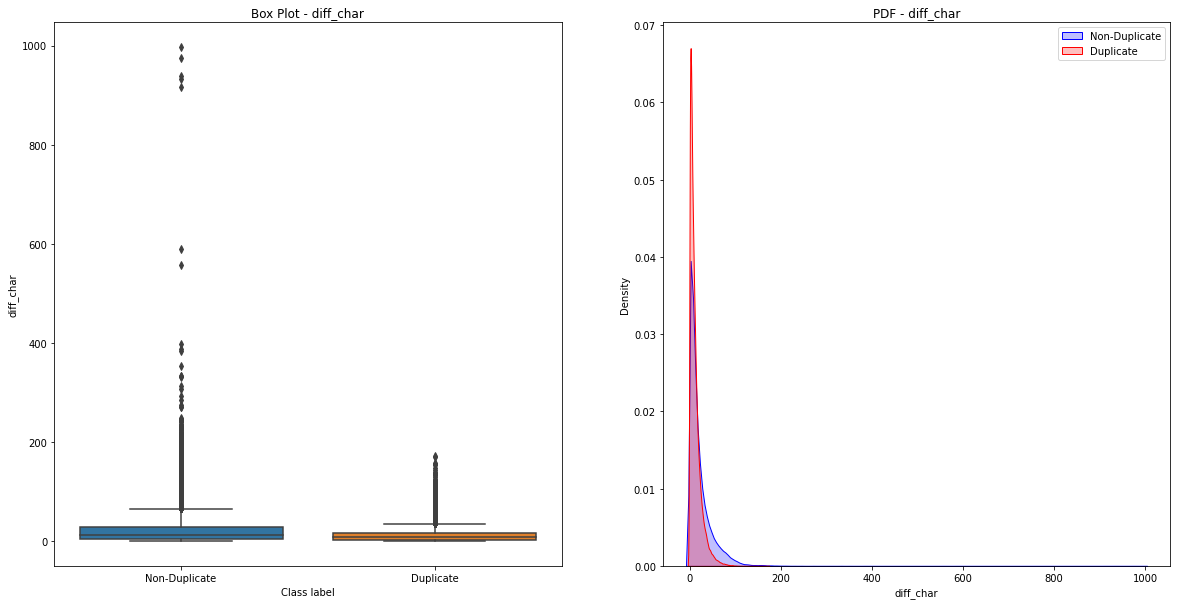

In [ ]:
#plot distribution of Characters diff
plot_distribution(fix_data, 'diff_char')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


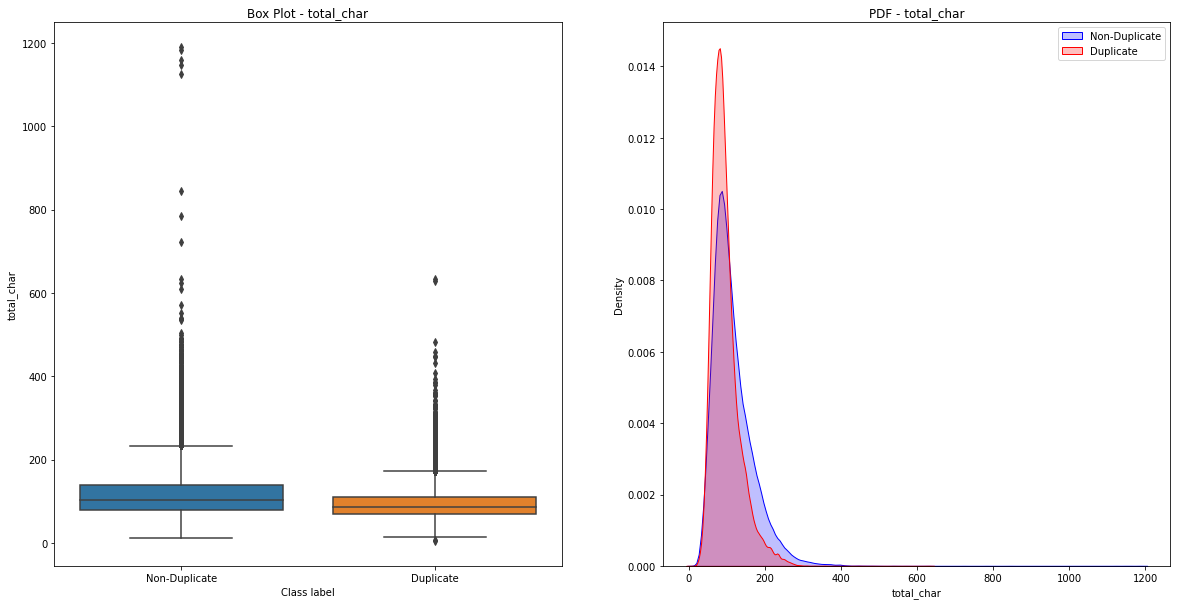

In [ ]:
#plot distribution of total Characters
plot_distribution(fix_data, 'total_char')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


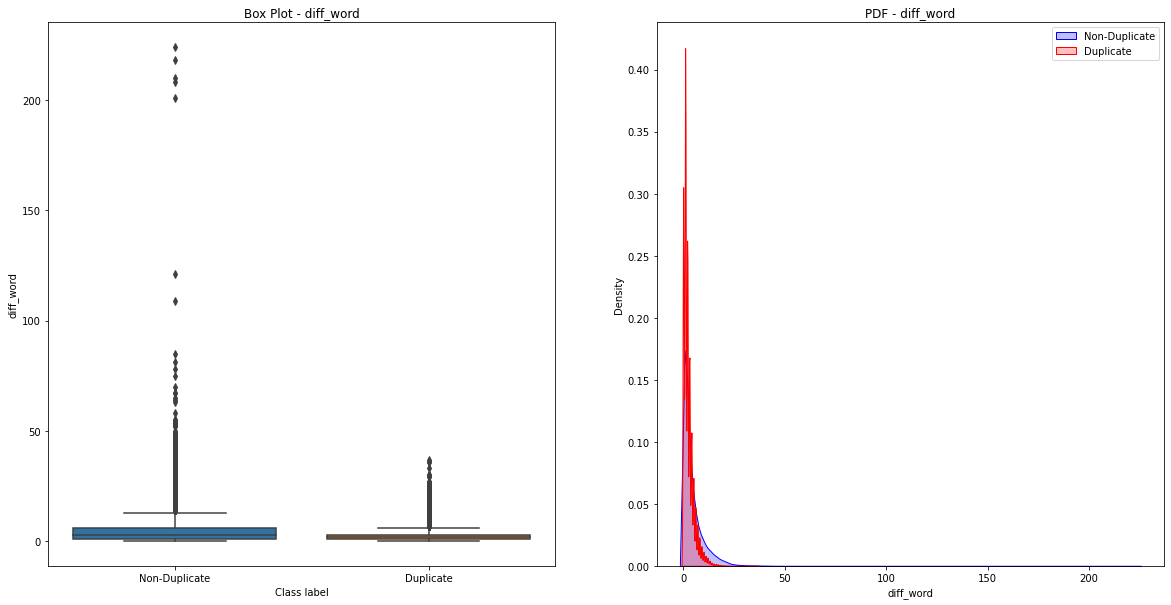

In [ ]:
#plot distribution of  words difference
plot_distribution(fix_data, 'diff_word')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


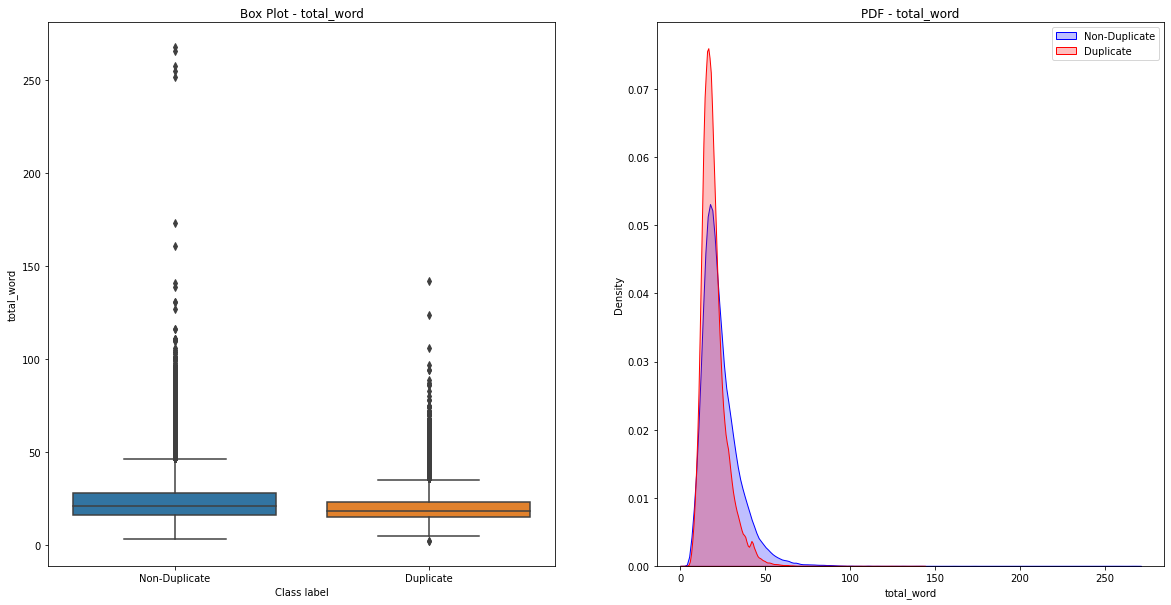

In [ ]:
#plot distribution of total words
plot_distribution(fix_data, 'total_word')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


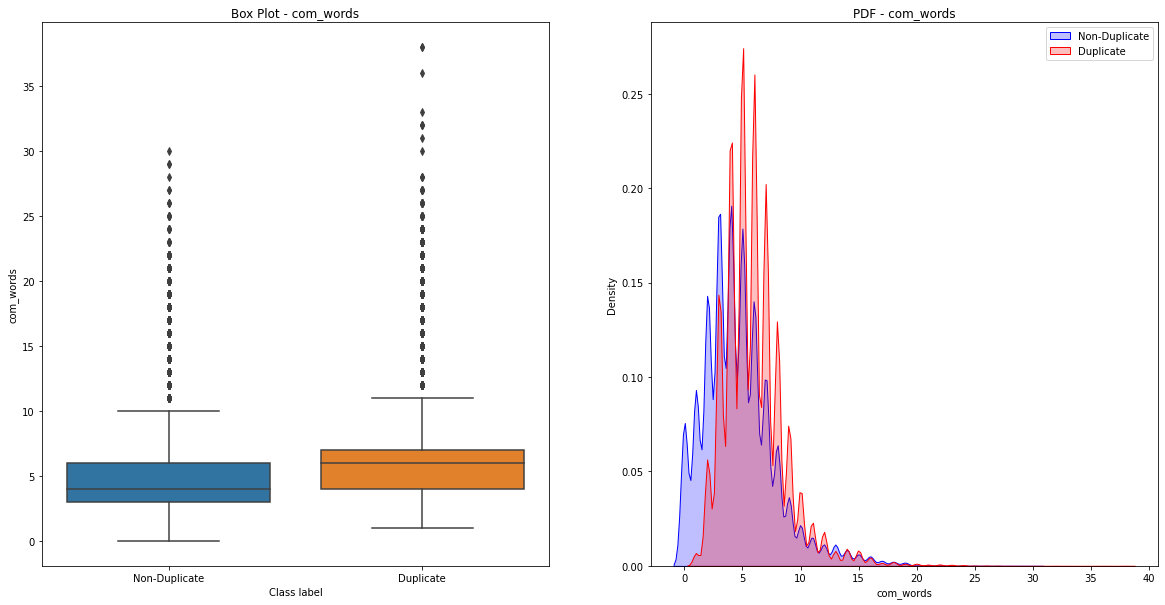

In [ ]:
#plot distribution of common words
plot_distribution(fix_data, 'com_words')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


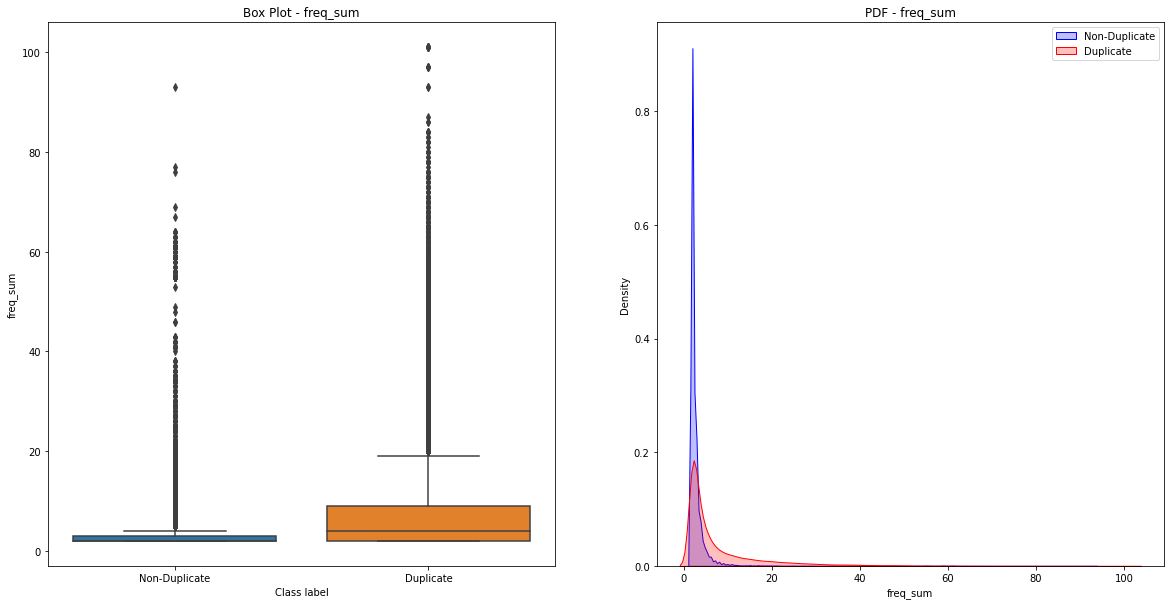

In [ ]:
#plot distribution of freqency sum
plot_distribution(fix_data, 'freq_sum')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


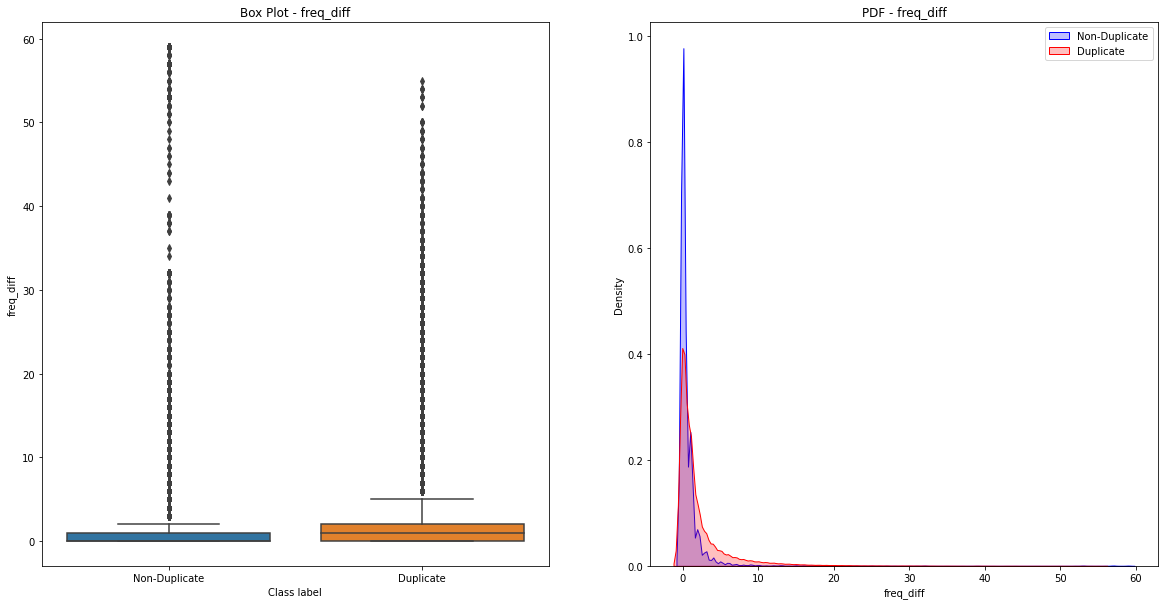

In [ ]:
#plot distribution of frequency difference
plot_distribution(fix_data, 'freq_diff')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


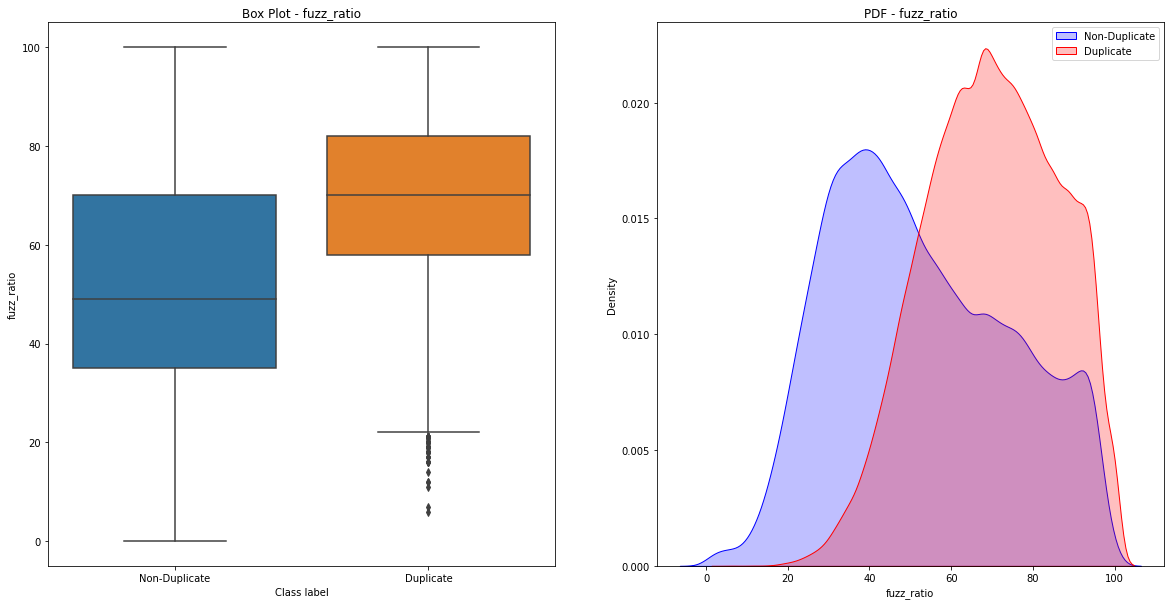

In [ ]:
#plot distribution of fuzz ratio
plot_distribution(fix_data, 'fuzz_ratio')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


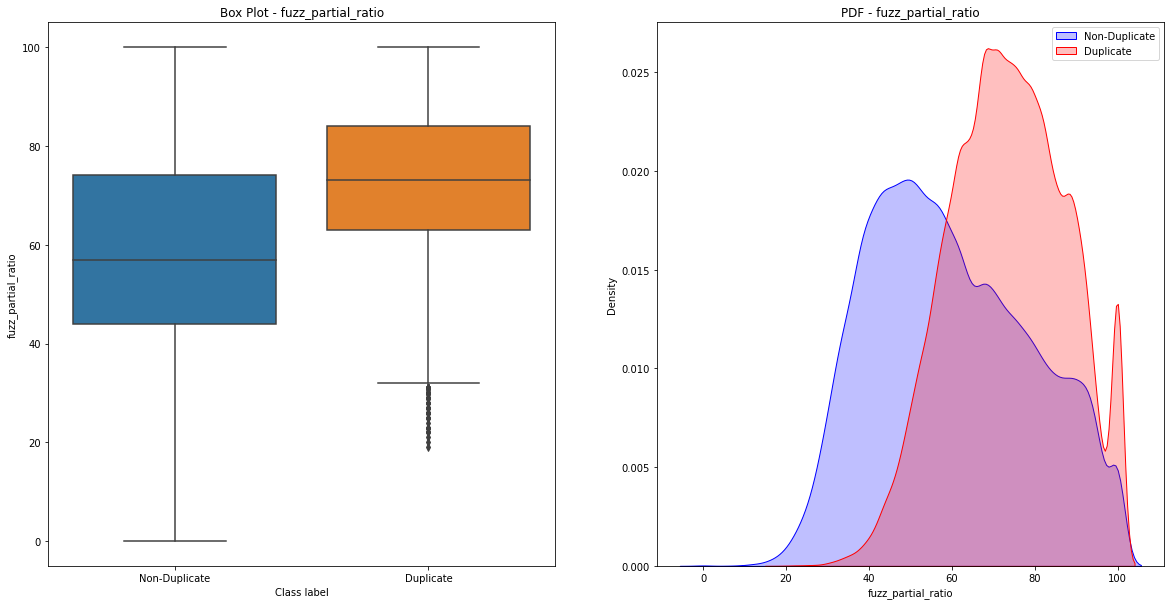

In [ ]:
#plot distribution of fuzz partial ratio
plot_distribution(fix_data, 'fuzz_partial_ratio')

### Word Cloud on normalized data

In [ ]:
# Splitting using class label
dup = fix_data[fix_data['is_duplicate']==1]
non_dup = fix_data[fix_data['is_duplicate']==0]

# Flattening to get 1D array
dup = np.array([dup['new_q1'], dup['new_q2']]).flatten()
dup = [str(word) for word in dup]

non_dup = np.array([non_dup['new_q1'], non_dup['new_q2']]).flatten()
non_dup = [str(word) for word in non_dup]


# Converting into one single string for word cloud
dup_str = ' '.join(dup)
non_dup_str = ' '.join(non_dup)

# Creating stopwords set, we use the same set we did while preprocessing
# Technically, this shouldnt change anything as we have already filtered the sentences
stop_words = set(stopwords.words('english'))

Word cloud for duplicate pairs


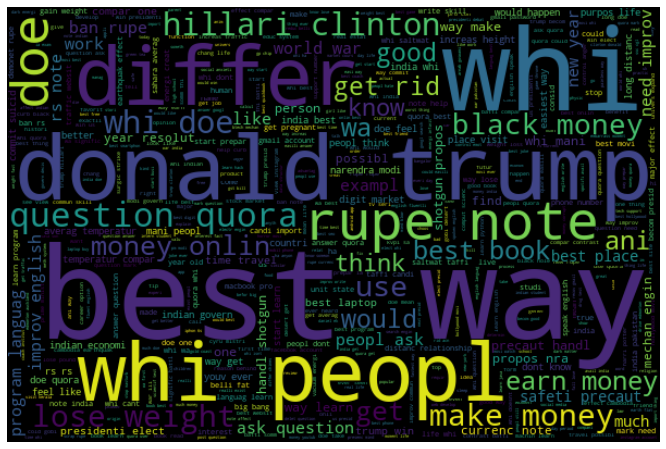

In [ ]:
# Generate duplicate pair word cloud
word_cloud = WordCloud(background_color='black', max_words=len(dup_str), stopwords=stop_words, width=600, height=400)
word_cloud.generate(dup_str)

print('Word cloud for duplicate pairs')
plt.figure(figsize=(15,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

plt.show()

### Try TSNE dimension

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

In [ ]:
dfp_subsampled = fix_data[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['char_q1', 'char_q2', 
                        'words_q1', 'words_q2',
                        'total_char', 'total_word', 'com_words',
                        'fuzz_ratio', 'fuzz_partial_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [ ]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.010s...
[t-SNE] Computed neighbors for 5000 samples in 0.275s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.035187
[t-SNE] Computed conditional probabilities in 0.288s
[t-SNE] Iteration 50: error = 86.7865448, gradient norm = 0.0424013 (50 iterations in 2.339s)
[t-SNE] Iteration 100: error = 75.1274567, gradient norm = 0.0043963 (50 iterations in 1.968s)
[t-SNE] Iteration 150: error = 74.4435349, gradient norm = 0.0016094 (50 iterations in 1.868s)
[t-SNE] Iteration 200: error = 74.2901764, gradient norm = 0.0008445 (50 iterations in 1.888s)
[t-SNE] Iteration 250: error = 74.2306061, gradient norm = 0.0005053

/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:581: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



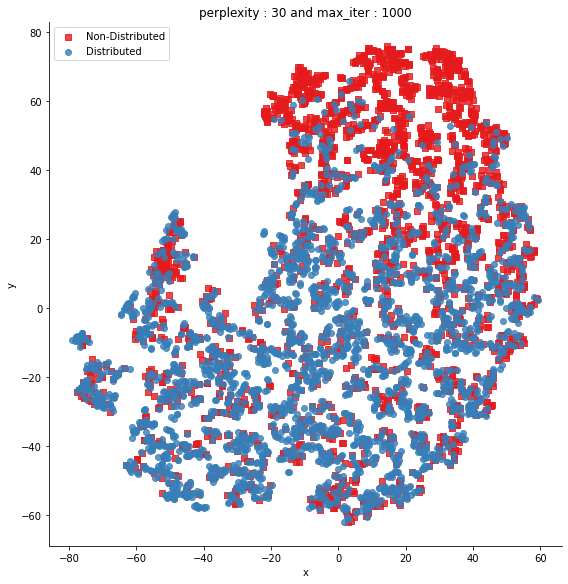

In [ ]:
tsne_df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=tsne_df, x='x', y='y', hue='label', 
           fit_reg=False, size=8,palette="Set1",markers=['s','o'],
           legend = False)
plt.legend(labels = ['Non-Distributed', 'Distributed'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [ ]:
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.011s...
[t-SNE] Computed neighbors for 5000 samples in 0.246s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.035187
[t-SNE] Computed conditional probabilities in 0.294s
[t-SNE] Iteration 50: error = 85.8701172, gradient norm = 0.0323782 (50 iterations in 10.019s)
[t-SNE] Iteration 100: error = 75.0768890, gradient norm = 0.0014143 (50 iterations in 7.808s)
[t-SNE] Iteration 150: error = 74.7211914, gradient norm = 0.0007081 (50 iterations in 8.400s)
[t-SNE] Iteration 200: error = 74.6430511, gradient norm = 0.0004271 (50 iterations in 8.737s)
[t-SNE] Iteration 250: error = 74.6080780, gradient norm = 0.000306

### apply to test

# Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, classification_report

In [25]:
#create deep copy
new_train = copy.deepcopy(fix_data)

In [26]:
#split new_test data into X, y
y = new_train.pop('is_duplicate')
X = new_train.drop(['id', 'qid1','qid2', 'question1', 'question2',
                    'new_q1', 'new_q2', 'no_char_q1', 'no_char_q2',
                    'no_words_q1', 'no_words_q2'], axis = 1)

#scale X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    test_size = 0.3,
                                                    stratify = y,
                                                    random_state = 42)

In [27]:
#retrieved from: https://github.com/sourvad/QuoraQuestionPairs/blob/main/QuoraQuestionPairs.ipynb
def plot_confusion_matrices(true, pred):
  # Normal confusion matrix
  conf = confusion_matrix(true, pred)
  
  # Precision matrix
  # Precision: Out of all the points predicted of class 'A', how many are actually class 'A'
  # A column in the confusion matrix represents the data points predicted as the same class
  # So we divide all data points by the sum of points in their respective columns
  precision = (conf.T / conf.sum(axis=1)).T

  # Recall matrix
  # Recall: Out of all the points which are of class 'A', how many were predicted to be of class 'A'
  # A row in the confusion matrix represents the data points of the same class
  # So we divide all data points by the sum of points in their respective rows
  recall = (conf / conf.sum(axis=0))

  # Plotting the matrices
  plt.figure(figsize=(24,6))

  # Set axes labels
  labels = ['0', '1']

  # Set colourmap
  cmap = sns.light_palette('orange')

  # Plot normal confusion matrix
  plt.subplot(1, 3, 1)
  sns.heatmap(conf, cmap=cmap, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')

  # Plot precision confusion matrix
  plt.subplot(1, 3, 2)
  sns.heatmap(precision, cmap=cmap, annot=True, fmt='.3f', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Precision Matrix')

  # Plot recall confusion matrix
  plt.subplot(1, 3, 3)
  sns.heatmap(recall, cmap=cmap, annot=True, fmt='.3f', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Recall Matrix')

  plt.show()

## Logistic Regression

In [43]:
#instantiate log regression
log_reg = LogisticRegression(random_state=10)

#define params grid
log_params = {'penalty' : ['l2','l1'],
              'C': [0.001, 0.1, 1,10],
              'solver': ['sag', 'saga']}

log_grid = GridSearchCV(log_reg, param_grid= log_params, cv = 5)

log_grid.fit(X_scaled, y)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solver

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=10),
             param_grid={'C': [0.001, 0.1, 1, 10], 'penalty': ['l2', 'l1'],
                         'solver': ['sag', 'saga']})

In [44]:
#print best params
print(log_grid.best_params_)
print(log_grid.best_estimator_.coef_)

{'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}
[[-0.14006578 -0.4530607   0.11364497 -0.28381197  0.67298613  0.32914537]]


In [45]:
#Predict X_test
y_reg = log_grid.predict(X_test)

In [46]:
#Check metrics
print("Log. Reg Confusion Matrix\n", confusion_matrix(y_test,y_reg))
print("Log. Reg accuracy:", accuracy_score(y_test, y_reg))
print("Log. Reg Roc Score:", roc_auc_score(y_test, log_grid.predict_proba(X_test)[:,1]))
print("Log. Reg F1 Score:", f1_score(y_test, y_reg))

Log. Reg Confusion Matrix
 [[21041 12562]
 [ 9258 24339]]
Log. Reg accuracy: 0.6752976190476191
Log. Reg Roc Score: 0.7239247803423708
Log. Reg F1 Score: 0.6904876734091748


In [47]:
#check classification report
print(classification_report(y_test, y_reg))

              precision    recall  f1-score   support

           0       0.69      0.63      0.66     33603
           1       0.66      0.72      0.69     33597

    accuracy                           0.68     67200
   macro avg       0.68      0.68      0.67     67200
weighted avg       0.68      0.68      0.67     67200



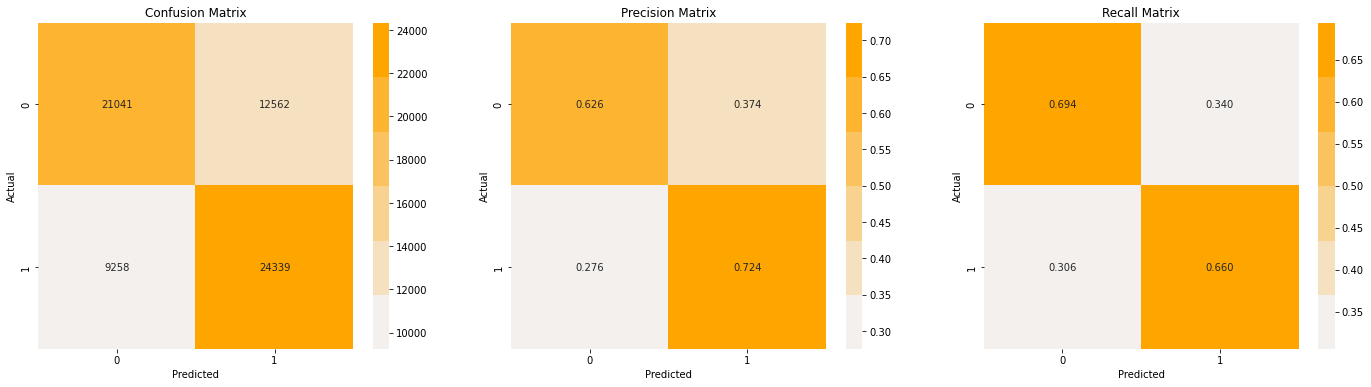

In [48]:
#plot confusion matrices
plot_confusion_matrices(y_test, y_reg)

## SVC

In [ ]:
from sklearn.svm import SVC
#instantiate log regression
svc = SVC(random_state=20)

#define params grid
svc_params = {'C' : [0.01, 0.1, 1],
              'kernel': ['linear', 'rbf', 'sigmoid']}

svc_grid = GridSearchCV(svc, param_grid= svc_params, cv = 5)

svc_grid.fit(X_train, y_train)

In [ ]:
#print best params
print(svc_grid.best_params_)

In [ ]:
#Predict X_test
y_svc = svc_grid.predict(X_test)

#Check metrics
print("SVC Confusion Matrix\n", confusion_matrix(y_test,y_svc))
print("SVC accuracy:", accuracy_score(y_test, y_svc))
print("SVC Roc Score:", roc_auc_score(y_test, svc_grid.predict_proba(X_test)[:,1]))
print("SVC F1 Score:", f1_score(y_test, y_svc))

In [ ]:
#check classification report
print(classification_report(y_test, y_svc))

In [ ]:
#plot confusion matrices
plot_confusion_matrices(y_test, y_svc)

## Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier
#instantiate log regression
rfc = RandomForestClassifier(random_state=30)

#define params grid
rfc_params = {'n_estimators' : [300, 400, 500],
              'max_depth': [200, 250, 300, 350],
              'max_features': ['sqrt']}

rfc_grid = GridSearchCV(rfc, param_grid= rfc_params, cv = 5)

rfc_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=30),
             param_grid={'max_depth': [200, 250, 300, 350],
                         'max_features': ['sqrt'],
                         'n_estimators': [300, 400, 500]})

In [51]:
#print best params
print(rfc_grid.best_params_)

{'max_depth': 200, 'max_features': 'sqrt', 'n_estimators': 300}


In [52]:
#Predict X_test
y_rfc = rfc_grid.predict(X_test)

In [53]:
#Check metrics
print("Random Forest Confusion Matrix\n", confusion_matrix(y_test,y_rfc))
print("Random Forest accuracy:", accuracy_score(y_test, y_rfc))
print("Random Forest Roc Score:", roc_auc_score(y_test, rfc_grid.predict_proba(X_test)[:,1]))
print("Random Forest F1 Score:", f1_score(y_test, y_rfc))

Random Forest Confusion Matrix
 [[21806 11797]
 [ 8437 25160]]
Random Forest accuracy: 0.6988988095238096
Random Forest Roc Score: 0.7675534340525625
Random Forest F1 Score: 0.7132125747654279


In [54]:
#check classification report
print(classification_report(y_test, y_rfc))

              precision    recall  f1-score   support

           0       0.72      0.65      0.68     33603
           1       0.68      0.75      0.71     33597

    accuracy                           0.70     67200
   macro avg       0.70      0.70      0.70     67200
weighted avg       0.70      0.70      0.70     67200



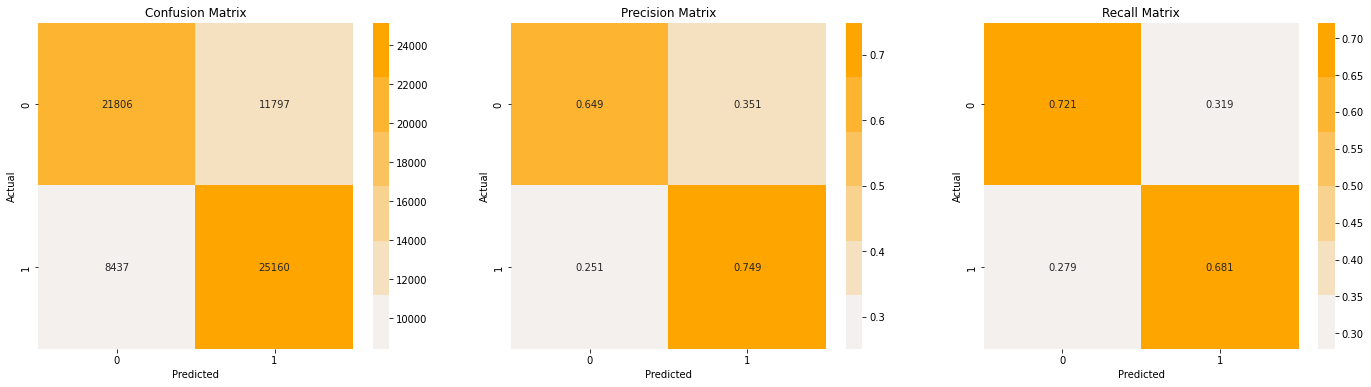

In [55]:
#plot confusion matrices
plot_confusion_matrices(y_test, y_rfc)

## XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state = 40)

xgb_param = {'max_depth' : range(50, 400, 50),
              'n_estimators': range(50, 300, 50),
              'learning_rate': [0.01, 0.05, 0.1]}

xgb_grid = GridSearchCV(estimator = xgb, param_grid= xgb_param, cv = 5)

xgb_grid.fit(X_train, y_train)

In [ ]:
#print best params
print(xgb_grid.best_estimator_)

In [59]:
#Predict X_test
y_xgb = xgb_grid.predict(X_test)

#Check metrics
print("XGBoost Confusion Matrix\n", confusion_matrix(y_test,y_xgb))
print("XGBoost accuracy:", accuracy_score(y_test, y_xgb))
print("XGBoost Roc Score:", roc_auc_score(y_test, xgb_grid.predict_proba(X_test)[:,1]))
print("XGBoost F1 Score:", f1_score(y_test, y_xgb))

NotFittedError: ignored

In [ ]:
#check classification report
print(classification_report(y_test, y_xgb))

In [ ]:
#plot confusion matrices
plot_confusion_matrices(y_test, y_xgb)